# Improving the model with a LJ baseline

In the previous notebook, we saw that our initial model was not very stable. One
possible improvement would be to add a Lennard-Jones potential as a baseline,
ensuring the model is repulsive at short distances.

In [1]:
from typing import List, Dict, Optional
import math

import torch

torch.manual_seed(123456)

import numpy as np
import matplotlib.pyplot as plt
import ase.io

from metatensor.torch import TensorBlock, Labels
from metatensor.torch.atomistic import System as MetatensorSystem
from metatensor.torch.atomistic import NeighborsListOptions
from metatensor.torch.atomistic import ModelCapabilities, ModelOutput, ModelRunOptions
from metatensor.torch.atomistic import MetatensorAtomisticModule
from metatensor.torch.atomistic.ase_calculator import MetatensorCalculator


## Defining a Lennard-Jones energy module

The Lennard-Jones potential is a classical potential with the following functional form:

$$
E = \sum_{ij} 4 \varepsilon \left[\left(\frac{\sigma}{r_{ij}}\right)^{12} - \left(\frac{\sigma}{r_{ij}}\right)^6\right]
$$

Where the sum runs over all pairs in the system with a distance below the cutoff radius $r_c$.

Using the formula above directly however comes with discontinuity issues: as the
atoms enter and leave the cutoff, there is a jump and discontinuity in energies.
One solution is to shift the energy to 0 at the cutoff, leaving only a small
discontinuity in the forces.

$$
E = \sum_{ij} 4 \varepsilon \left[\left(\frac{\sigma}{r_{ij}}\right)^{12} - \left(\frac{\sigma}{r_{ij}}\right)^6\right] - 4 \varepsilon \left[\left(\frac{\sigma}{r_c}\right)^{12} - \left(\frac{\sigma}{r_c}\right)^6\right]
$$

To be able to compute the Lennard-Jones energy of a system, we need a list of
all pairs below the cutoff. Ideally, we will want to get such list of pairs
directly from the MD engine, which can use some trick for a faster
re-calculation of the list. For a metatensor atomistic model, this can be
achieved by requesting some neighbors lists with a `requested_neighbors_lists()`
function, and then accessing these neighbors lists in the `forward()` function.


| ![TASK](../images/clipboard.png) | Modify the loop over pairs in `forward()` to compute the LJ energy |
|-------------------------------|--------------------------------------------------------------------|

In [2]:
class LennardJones(torch.nn.Module):
    def __init__(self, cutoff, parameters: Dict[int, Dict[str, float]]):
        super().__init__()
        self.cutoff = float(cutoff)

        # The neighbors list request we are making:
        self._neighbors = NeighborsListOptions(cutoff=self.cutoff, full_list=False)

        self._lj_params = {}
        for s_i, p_i in parameters.items():
            sigma_i = p_i["sigma"]
            epsilon_i = p_i["epsilon"]
            self._lj_params[s_i] = {}

            for s_j, p_j in parameters.items():
                sigma_j = p_j["sigma"]
                epsilon_j = p_j["epsilon"]

                # combine parameters with Lorentz-Berthelot rules
                sigma = (sigma_i + sigma_j) / 2
                epsilon = math.sqrt(epsilon_i * epsilon_j)

                # compute the energy at the cutoff for these parameters, to remove it
                # from the energy of a pair in forward
                energy_at_cutoff = (
                    4 * epsilon * ((sigma / cutoff) ** 12 - (sigma / cutoff) ** 6)
                )

                self._lj_params[s_i][s_j] = [sigma, epsilon, energy_at_cutoff]

    # exposed the requested neighbors list so metatensor can find it
    def requested_neighbors_lists(self) -> List[NeighborsListOptions]:
        return [self._neighbors]

    def forward(
        self,
        system: MetatensorSystem,
        run_options: ModelRunOptions,
    ) -> Dict[str, TensorBlock]:
        if "energy" not in run_options.outputs:
            return {}

        # The neighbors list was computed by the MD engine and
        # is available as a TensorBlock
        neighbors = system.get_neighbors_list(self._neighbors)
        # the samples of this block are
        #     first_atom   second_atom   cell_shift_a   cell_shift_b   cell_shift_c
        all_i = neighbors.samples.column("first_atom")
        all_j = neighbors.samples.column("second_atom")
        all_S = neighbors.samples.view(
            ["cell_shift_a", "cell_shift_b", "cell_shift_c"]
        ).values

        # The system contains data about the positions and cell, also as TensorBlock
        cell = system.cell.values.reshape(3, 3)
        positions = system.positions.values.reshape(-1, 3)

        # system.positions samples are "atom" and "species", we need the species here
        # to access the right LJ parameters
        species = system.positions.samples.column("species")

        selected_atoms = run_options.selected_atoms
        if selected_atoms is None:
            selected_atoms = [i for i in range(positions.shape[0])]

        total_energy = torch.zeros(1, dtype=positions.dtype)
        # loop over all pairs
        for i, j, S in zip(all_i, all_j, all_S):
            # get the parameters for the current pair of species
            sigma, epsilon, shift = self._lj_params[int(species[i])][int(species[j])]
            # compute the distance between the two atoms
            distance = positions[j] - positions[i] + S.to(dtype=cell.dtype) @ cell

            # square of the distance between the atoms
            r2 = distance.dot(distance)

            r = r2.sqrt()
            e_ij = 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)

            total_energy += e_ij - shift

        # as previously, return a Dict of TensorBlock containing the energy
        return {
            "energy": TensorBlock(
                values=total_energy.reshape(1, 1),
                samples=Labels(["_"], torch.IntTensor([[0]])),
                components=[],
                properties=Labels(["energy"], torch.IntTensor([[0]])),
            )
        }


In [3]:
# energies in eV and distances in Angstroms
LJ_PARAMETERS = {
    1: {"sigma": 2.32, "epsilon": 3.3104e-6},
    6: {"sigma": 2.94, "epsilon": 2.3309e-6},
    8: {"sigma": 2.66, "epsilon": 2.4673e-6},
}

lj = LennardJones(cutoff=6.0, parameters=LJ_PARAMETERS)
lj = lj.eval()


In [4]:
# Read the data
frames = ase.io.read("../propenol_conformers_dftb.xyz", ":500")


Now that we have a custom Lennard-Jones implementation, we can use the same 
facilities to export it as a `MetatensorAtomisticModule` and use it in 
ASE.

In [5]:
capabilities = ModelCapabilities(
    length_unit="angstrom",
    species=[1, 6, 8],
    outputs={
        "energy": ModelOutput(
            quantity="energy",
            unit="eV",
            per_atom=False,
        ),
    },
)

# when using `MetatensorCalculator`, the neighbors lists are provided by ASE.
#
# notice that we don't need to export the model to a file to be able to use it with ASE.
ase_calculator = MetatensorCalculator(MetatensorAtomisticModule(lj, capabilities))


We'll start by checking that the code runs and produces a reasonable output.

In [6]:
# check that the code runs fine on the first frame
atoms = frames[0]
atoms.calc = ase_calculator

energy = atoms.get_potential_energy()
if abs(energy - 3.05) > 0.1:
    raise Exception(f"the energy seems wrong: {energy}")


Now, we can modify our training set to remove the part accounted for by the LJ module

In [7]:
energies = []
forces = []

# remove the LJ energies and forces from the targets
for atoms in frames:
    atoms.calc = ase_calculator
    energies.append(atoms.info["energy"] - atoms.get_potential_energy())
    forces.append(atoms.arrays["forces"] - atoms.get_forces())

energies = np.vstack(energies)
forces = np.vstack(forces)


## Training the NN, again!

Let's load back our model, and re-train it on the new targets!

In [8]:
import rascaline.torch
from rascaline.torch import (
    SoapPowerSpectrum,
    systems_to_torch,
    metatensor_system_to_rascaline,
)


In [9]:
# this is the same definition as in notebook 1


class SOAPModel(torch.nn.Module):
    def __init__(self, soap_parameters, species, energy_offset):
        super().__init__()

        self.energy_offset = torch.tensor(energy_offset)
        self.species = species

        self.soap_calculator = SoapPowerSpectrum(**soap_parameters)
        self.species_pairs = torch.IntTensor(
            [(i, j) for i in species for j in species if i <= j]
        )

        # Number of features produced by the SOAP calculator,
        # i.e. size of the input of the NN
        n_soap = (
            (soap_parameters["max_angular"] + 1)
            * soap_parameters["max_radial"] ** 2
            * len(self.species_pairs)
        )

        # Definition of our NN: one hidden layer,
        # SiLU activation, 128-sized latent space
        self.soap_nn = torch.nn.Sequential(
            torch.nn.Linear(
                in_features=n_soap, out_features=128, bias=False, dtype=torch.float64
            ),
            torch.nn.SiLU(),
            torch.nn.Linear(
                in_features=128, out_features=128, bias=False, dtype=torch.float64
            ),
            torch.nn.SiLU(),
            torch.nn.Linear(
                in_features=128, out_features=1, bias=True, dtype=torch.float64
            ),
        )

    def forward(
        self,
        systems: List[rascaline.torch.System],
        selected_samples: Optional[Labels] = None,
    ):
        energies = torch.zeros((len(systems), 1), dtype=torch.float64)
        for i, system in enumerate(systems):
            soap = self.soap_calculator([system], selected_samples=selected_samples)
            soap = soap.keys_to_properties(
                Labels(["species_neighbor_1", "species_neighbor_2"], self.species_pairs)
            )
            soap = soap.keys_to_samples("species_center")

            energies_per_atom = self.soap_nn(soap.block().values)
            energies[i] = energies_per_atom.sum()

        return energies + self.energy_offset


In [10]:
SOAP_PARAMETERS = {
    "cutoff": 3.5,
    "max_radial": 6,
    "max_angular": 6,
    "atomic_gaussian_width": 0.3,
    "center_atom_weight": 1.0,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
}

model = SOAPModel(
    SOAP_PARAMETERS,
    species=[1, 6, 8],
    energy_offset=energies.mean(),
)


In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)
epoch = -1

systems = systems_to_torch(frames)
reference = torch.tensor(energies)

mse_loss = torch.nn.MSELoss()


The training procedure will be very similar to the previous one.

| ![TASK](../images/clipboard.png) | Run the training loop until the loss is below 0.05 |
|-------------------------------|----------------------------------------------------|

In [12]:
start = epoch + 1

for epoch in range(start, start + 75):
    optimizer.zero_grad()
    prediction = model(systems)
    loss = mse_loss(prediction, reference)
    print(f"loss at epoch {epoch} is", loss.item())

    loss.backward()
    optimizer.step()


loss at epoch 0 is 1.737128042777268
loss at epoch 1 is 1.2873484537455508
loss at epoch 2 is 1.8770152993845213
loss at epoch 3 is 1.2356845331506112
loss at epoch 4 is 1.512921532607367
loss at epoch 5 is 1.498359656794797
loss at epoch 6 is 1.2943379770133288
loss at epoch 7 is 1.1979625052534892
loss at epoch 8 is 1.2228009243064648
loss at epoch 9 is 1.2595810298748402
loss at epoch 10 is 1.234321160639316
loss at epoch 11 is 1.1849502919855193
loss at epoch 12 is 1.1626552694408476
loss at epoch 13 is 1.1699156420920445
loss at epoch 14 is 1.1774440049290247
loss at epoch 15 is 1.1607306364890553
loss at epoch 16 is 1.1204477392977006
loss at epoch 17 is 1.076893057352748
loss at epoch 18 is 1.0500365467038772
loss at epoch 19 is 1.0359400928865834
loss at epoch 20 is 1.0037545143543956
loss at epoch 21 is 0.9400337605812809
loss at epoch 22 is 0.8750236535423732
loss at epoch 23 is 0.8328638162744044
loss at epoch 24 is 0.7765845415865276
loss at epoch 25 is 0.6675223366775874
l

In [13]:
if loss.item() > 0.05:
    raise Exception(
        f"loss is still too high, please continue running the training loop"
    )


We can check the output against the reference (without the LJ contributions)

Text(0, 0.5, 'predicted')

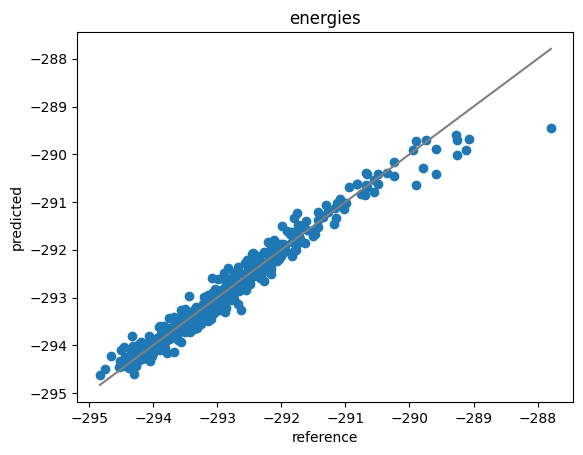

In [14]:
predicted_energy = model(systems)

plt.scatter(energies, predicted_energy.detach().numpy())

x = [np.min(energies), np.max(energies)]
plt.plot(x, x, c="grey")

plt.title("energies")
plt.xlabel("reference")
plt.ylabel("predicted")


## Re-assemble the full model

We can now assemble a new model using both the LJ contributions and the
re-trained SOAP neural network. We'll run both here, and add their outputs.

In [15]:
class ExportWrapper(torch.nn.Module):
    def __init__(self, lj, nn_model):
        super().__init__()
        self.lj = lj
        self.nn_model = nn_model

    def forward(
        self,
        system: MetatensorSystem,
        run_options: ModelRunOptions,
    ) -> Dict[str, TensorBlock]:
        if "energy" not in run_options.outputs:
            return {}

        # run the LJ model
        outputs = self.lj(system, run_options)
        lj_energy = outputs["energy"]

        # run the NN model
        selected_atoms = run_options.selected_atoms
        if selected_atoms is None:
            selected_samples = None
        else:
            selected_samples = Labels(
                "center", torch.IntTensor(selected_atoms).reshape(-1, 1)
            )

        nn_energy = self.nn_model(
            metatensor_system_to_rascaline(system),
            selected_samples=selected_samples,
        )

        return {
            "energy": TensorBlock(
                values=lj_energy.values + nn_energy.reshape(1, 1),
                samples=Labels("_", torch.IntTensor([[0]])),
                components=[],
                properties=Labels("energy", torch.IntTensor([[0]])),
            )
        }


With this done, we can define the capabilities of our new model, and export it to a file

In [16]:
wrapper = ExportWrapper(lj, model)
wrapper = wrapper.eval()

capabilities = ModelCapabilities(
    length_unit="angstrom",
    species=[1, 6, 8],
    outputs={
        "energy": ModelOutput(
            quantity="energy",
            unit="eV",
            per_atom=False,
        ),
    },
)

metatensor_model = MetatensorAtomisticModule(wrapper, capabilities)
metatensor_model.export("propenol-model-with-lj.pt")


## Running some MD with our new model

Let's see if these changes have made a difference to the stability of the model.

In [17]:
import ase.md
import ase.units

import chemiscope


In [18]:
# Using the same initial setup for the simulation

atoms = frames[0]
atoms.calc = MetatensorCalculator("propenol-model-with-lj.pt")

integrator = ase.md.VelocityVerlet(atoms, timestep=1 * ase.units.fs)


In [19]:
trajectory = [atoms.copy()]

for _ in range(200):
    integrator.run(1)
    trajectory.append(atoms.copy())


In [20]:
chemiscope.show(
    trajectory, mode="structure", settings={"structure": [{"playbackDelay": 50}]}
)


StructureWidget(value='{"meta": {"name": " "}, "settings": {"structure": [{"playbackDelay": 50}]}, "structures…

We have fixed the issue of atoms getting way too close to one another! 🎉

We still have other problems, from the fairly low accuracy to the molecule now
decomposing into individual atoms. There would be a handful of approaches to
improve on this point (see at the end of notebook 2-ASE-md). If you have some
time, feel free to go back to the model definition and training and improve on
these points!

For now, we'll see how we can take the exact same potential we just use in ASE
and use it in a completely different simulation engine: LAMMPS.